In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import math
import time
import random
import torch
import scipy.io
import torchvision
import numpy as np
import collections
import pandas as pd
import torch.nn as nn
import seaborn as sns
from PIL import Image
from fastai.basics import *
from fastai.vision import *
from sklearn import metrics
from matplotlib import pyplot as plt
from fastai.callbacks.hooks import *
import torch.utils.data as data_utils
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [0]:
def train_test_eq_split(X, y, n_per_class, random_state=None):
    if random_state:
        np.random.seed(random_state)
    sampled = X.groupby(y[0], sort=False).apply(lambda frame: frame.sample(n_per_class))
    mask = sampled.index.get_level_values(1)
    X_train = X.drop(mask)
    X_test = X.loc[mask]
    y_train = y.drop(mask)
    y_test = y.loc[mask]
    return X_train, X_test, y_train, y_test

In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Read Data

In [0]:
dir = '/content/drive/My Drive/Masters/MSc Data Science University of Tartu/Computational NeuroScience Project/'
#/content/drive/My Drive/Masters/MSc Data Science University of Tartu/Computational NeuroScience Project/6845348
most_images_data = scipy.io.loadmat(dir + '6845348/natimg2800_M170714_MP032_2017-09-14.mat')
images_categories = scipy.io.loadmat(dir + '6845348/stimuli_class_assignment.mat')
images = scipy.io.loadmat(dir + '6845348/images_natimg2800_all.mat')['imgs']
### stimulus responses
resp = most_images_data['stim'][0]['resp'][0] # stimuli by neurons
istim = most_images_data['stim'][0]['istim'][0] # identities of stimuli in resp
cats = images_categories['class_assignment'][0] # cateogries of stimuli

In [5]:
images.shape

(68, 270, 2800)

In [6]:
len(cats)

2800

#### Get Images Labels / Categories
Total = 17 classes

17 classes from 0 to 16 ('unknown', 'birds', 'cats', 'flowers', 'hamsters', 'holes', 'insects', 'mice', 'mushrooms', 'nests', 'pellets', 'snakes', 'wildcats', 'other animals', 'other natural', 'other man made', 'grey').


In [0]:
labels_str = ['unknown', 'birds', 'cats', 'flowers', 'hamsters', 'holes', 'insects', 'mice', 'mushrooms', 'nests', 
             'pellets', 'snakes', 'wildcats', 'animals', 'natural', 'man_made', 'grey']

labels = np.zeros(len(istim))
for i in range(len(istim)):
    if istim[i] - 1 == 2800:
        labels[i] = 16 #gray image
    else:
        labels[i] = cats[istim[i] - 1]

([<matplotlib.axis.XTick at 0x7f5babfe4c18>,
 <a list of 17 Text xticklabel objects>)

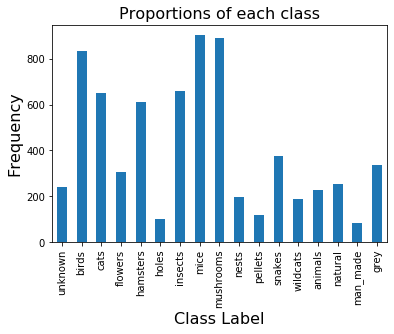

In [8]:
counter=collections.Counter(labels)
stars = pd.Series(labels)
vc = stars.value_counts().sort_index()
ax = vc.plot(kind='bar')
fig = ax.get_figure()
plt.title('Proportions of each class', fontsize = 16)
plt.xlabel('Class Label', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.xticks(np.arange(17), labels_str)

#### Convert data to pandas dataframes

In [0]:
X_data = pd.DataFrame(data = resp)
y_data = pd.DataFrame(data = labels)

In [10]:
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=22)
X_train, X_test, y_train, y_test = train_test_eq_split(X_data, y_data, n_per_class=75, random_state=22)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
#X_train, y_train = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# 2. Pretrained resnet34 and Fine Tune

In [0]:
#make batch size dimension to be the first dimension
images2 = np.transpose(images, (2, 0, 1))

In [12]:
#convert 1 channel to 3 channels
images2 = np.repeat(images2[:, np.newaxis, :, :], 3, axis=1)
images2 = images2[:,:,:,90:180]
#normalize by imagenet statistics
images2.astype('float64')
images2 = images2 / 255.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(3):
  images2[:, i, :, :] -= mean[i]
  images2[:, i, :, :] /= std[i]

images2.shape

(2800, 3, 68, 90)

In [13]:
images2.shape

(2800, 3, 68, 90)

##### Load Data into FastAI 

In [14]:
bs = 64
data_imgs = (ImageList.from_folder(dir + 'imgs_dataset')
              .split_by_folder(train='train', valid='valid')
              .label_from_folder()
              .databunch(bs=bs)
              ).normalize(imagenet_stats)
# information about the batch
data_imgs.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (6736 items)
x: ImageList
Image (3, 68, 90),Image (3, 68, 90),Image (3, 68, 90),Image (3, 68, 90),Image (3, 68, 90)
y: CategoryList
11,11,11,11,11
Path: /content/drive/My Drive/Masters/MSc Data Science University of Tartu/Computational NeuroScience Project/imgs_dataset;

Valid: LabelList (1680 items)
x: ImageList
Image (3, 68, 90),Image (3, 68, 90),Image (3, 68, 90),Image (3, 68, 90),Image (3, 68, 90)
y: CategoryList
1,1,1,1,1
Path: /content/drive/My Drive/Masters/MSc Data Science University of Tartu/Computational NeuroScience Project/imgs_dataset;

Test: None>

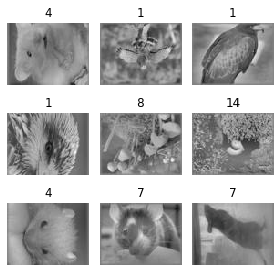

In [15]:
# take a look at the data
data_imgs.show_batch(rows=3, figsize=(4,4))

##### CE with Label Smoothing Class

In [0]:
class CELabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(CELabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

##### Call resnet34 Model and Fine Tune it.

In [0]:
metrics=[accuracy]
learner = cnn_learner(data_imgs, models.resnet50, pretrained = True,
                  #loss_func= CELabelSmoothingLoss(16, smoothing = 0.1), 
                  loss_func = nn.CrossEntropyLoss(),
                  metrics=metrics, opt_func=torch.optim.Adam)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


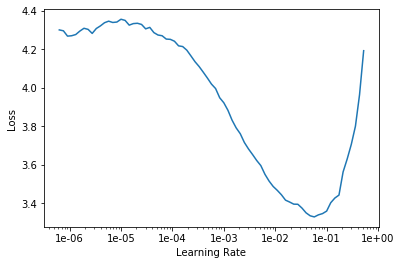

In [18]:
learner.lr_find()
learner.recorder.plot()

In [0]:
learner.save('before_finetune')

In [0]:
learner.unfreeze()

In [21]:
learner.fit_one_cycle(8, slice(3e-3))
learner.save('epochs8-lr_constant')

epoch,train_loss,valid_loss,accuracy,time
0,2.134921,1.540053,0.586905,00:18
1,1.302181,1.164692,0.666667,00:17
2,0.737031,1.016138,0.729167,00:17
3,0.404186,1.041478,0.744643,00:17
4,0.221546,1.106193,0.761905,00:18
5,0.122053,1.118239,0.772619,00:18
6,0.078854,1.140649,0.768452,00:17
7,0.053725,1.158501,0.767857,00:18


##### Feature Extraction

In [22]:
list(learner.model.modules())[-8]

Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)

In [0]:
images2 = torch.from_numpy(images2).float()

In [25]:
extracted_feats = {}
nn_module = list(learner.model.modules())[-8]
hook = hook_output(nn_module)
for i in range(len(images2)):
  learner.predict(images2[i])
  #print(hook.stored)
  extracted_feats[i] = hook.stored[0]
  #print(extracted_feats[i].shape)
  if i % 500 == 0:
    print('Finished:', i)

hook.remove

Finished: 0
Finished: 500
Finished: 1000
Finished: 1500
Finished: 2000
Finished: 2500


<bound method Hook.remove of <fastai.callbacks.hooks.Hook object at 0x7f5ba90d3e80>>

# 3. Clustering Extracted Features

In [0]:
for k in extracted_feats.keys():
  extracted_feats[k] = extracted_feats[k].cpu()

In [0]:
ext_feats = pd.DataFrame(extracted_feats).T

In [28]:
ext_feats.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,10.744389,0.000000,2.796412,6.626183,0.0,1.222000,3.825383,3.088619,2.293033,0.0,2.253655,1.554031,1.960479,8.468469,15.432325,2.116383,5.891634,2.728517,6.979760,1.290159,3.166271,5.810705,3.506717,8.496689,3.879761,5.120586,7.254268,6.459617,1.814313,1.986981,8.917271,15.169880,3.786226,0.767939,0.000000,0.949159,4.857079,0.0,0.742046,0.000000,...,3.201553,2.473815,0.550073,0.066791,0.066053,2.710093,0.757408,3.413386,0.083074,5.244166,13.470472,0.115737,5.580180,0.343306,0.168790,2.473127,0.126794,0.000000,1.313345,1.219912,3.720929,0.103604,2.074609,0.000000,0.000000,1.172527,0.694412,0.0,0.543998,0.076255,0.0,3.411864,0.520031,1.772017,0.343397,2.002815,0.125830,0.0,0.649708,0.000000
1,7.198118,0.000000,0.000000,4.352698,0.0,0.000000,1.663793,1.756646,1.041269,0.0,1.629326,0.766216,0.830063,6.597140,7.754549,1.703359,5.237693,3.698783,4.875448,0.905961,2.282221,8.079927,3.020255,6.515872,5.807674,1.844914,1.630133,6.631248,3.242497,1.448974,6.406960,9.628893,3.442003,0.643012,0.164047,0.287489,2.225367,0.0,0.488612,0.000000,...,2.025914,2.650903,0.808931,0.187474,0.000000,1.879230,0.266391,3.314963,0.000000,5.504141,13.099947,0.031436,4.244380,0.282670,0.112432,2.475549,0.145236,0.284132,0.000000,2.407858,4.027924,0.107496,1.109214,0.289185,0.000000,1.307840,0.795958,0.0,0.056588,1.395360,0.0,4.150660,0.559252,1.567640,0.994165,2.111207,0.055338,0.0,0.604710,0.000000
2,7.193620,0.000000,4.020304,2.288999,0.0,0.000000,5.637762,3.191499,0.341541,0.0,2.235256,0.639858,0.000000,8.824265,14.945010,2.161829,6.725821,3.250302,3.928330,1.738381,2.079230,6.158336,2.888870,5.199998,5.592185,5.263743,6.122088,4.945436,3.456422,2.584616,7.919046,11.248165,3.455562,1.288026,0.645026,1.135117,2.606594,0.0,2.135444,0.000000,...,2.279354,2.352281,1.208134,0.000000,0.000000,3.689939,0.486796,3.255919,0.000000,3.385890,8.115902,0.684835,4.704916,0.355987,0.007525,4.291235,0.210725,0.204215,0.289219,0.282185,3.438712,0.248250,1.392976,0.126018,0.047732,1.993901,0.317351,0.0,0.982135,0.000000,0.0,2.245749,0.843090,1.547755,0.548551,1.321234,0.008550,0.0,0.358687,0.000000
3,11.419470,0.000000,2.993738,6.502871,0.0,0.000000,3.201690,2.392269,0.000000,0.0,1.715993,2.107572,0.000000,9.712687,12.323680,4.426027,3.596845,3.442954,4.988086,1.848693,4.788485,8.747915,8.563996,10.009580,2.354554,4.024022,7.590975,8.026815,0.415787,3.715449,10.061794,15.538026,5.179610,0.773798,2.961007,0.563134,4.716862,0.0,2.208475,0.000000,...,1.938898,3.437009,2.121669,0.424803,0.000000,3.893338,0.018610,3.527111,0.000000,7.030622,11.833252,0.093269,4.570895,0.407573,0.125723,3.824655,0.400742,0.052755,1.064189,1.921705,2.708370,0.000000,0.359269,1.190872,0.000000,1.263917,0.804312,0.0,0.143090,1.017977,0.0,2.328813,0.287708,1.654292,2.216639,2.109476,0.017863,0.0,0.269684,0.000000
4,10.356987,1.099178,2.344774,4.536369,0.0,0.557173,4.849600,3.128931,2.047738,0.0,3.038564,0.266182,1.283234,9.321245,15.599375,3.628253,6.334742,3.373173,7.111654,1.410860,4.389361,7.052041,3.616566,6.560997,3.860571,4.250144,5.369758,8.057298,2.308592,1.784162,9.827514,14.059216,4.150100,2.129705,0.090617,0.428638,5.284666,0.0,0.602069,0.371693,...,2.406567,2.391441,1.151363,0.127895,0.000000,3.227964,1.484478,2.730726,0.109453,3.915398,9.931623,0.318140,6.990324,0.895492,0.026041,1.984933,0.551597,0.040320,1.577567,1.186077,4.825703,0.071351,3.004521,0.000000,0.448103,1.389635,0.862797,0.0,0.650991,0.087832,0.0,2.670537,1.414443,1.776792,0.244143,1.848131,0.043209,0.0,0.401835,0.009081


In [0]:
norm_data = ext_feats#(ext_feats - ext_feats.mean()) / ext_feats.std()

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
# k means determine k
silhs = []
K = range(2,17)
for k in K:
    model = KMeans(n_clusters = k).fit(norm_data)
    cluster_labels = model.fit_predict(norm_data)
    silhs.append(davies_bouldin_score(norm_data, cluster_labels))
    if k % 5 == 0:
      print('Finished: ', k)

Finished:  5
Finished:  10
Finished:  15


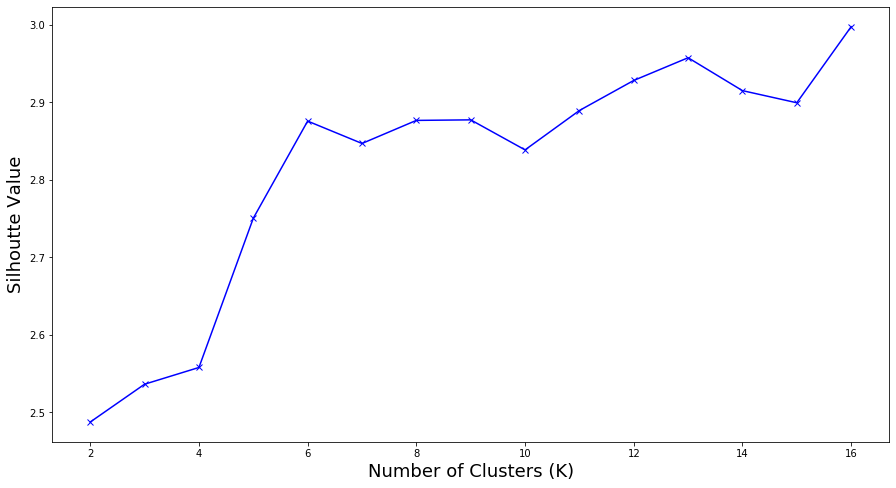

In [31]:
# Plot the elbow
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(K, silhs, 'bx-')
plt.xlabel('Number of Clusters (K)', fontsize = 18)
plt.ylabel('Silhoutte Value', fontsize = 18)
plt.show()

##### Use 5 clusters

In [0]:
model = KMeans(n_clusters = 6).fit(norm_data)

In [0]:
pred_labels = model.labels_

##### Check which classes are merged together

In [38]:
for i in range(5):
  print('Cluster #', i)
  counts = {}
  for j in range(16):
    counts[j] = 0
  for j in range(2800):
    if pred_labels[j] == i:
      counts[cats[j]] += 1
  for j in range(16):
    counts[j] = int(counts[j] / np.sum(cats == j) * 100 )
  print(counts, '\n###################################\n')

Cluster # 0
{0: 25, 1: 16, 2: 17, 3: 33, 4: 6, 5: 2, 6: 38, 7: 19, 8: 32, 9: 30, 10: 29, 11: 33, 12: 51, 13: 24, 14: 31, 15: 16} 
###################################

Cluster # 1
{0: 9, 1: 24, 2: 19, 3: 10, 4: 16, 5: 4, 6: 12, 7: 13, 8: 7, 9: 2, 10: 5, 11: 14, 12: 3, 13: 11, 14: 7, 15: 25} 
###################################

Cluster # 2
{0: 15, 1: 6, 2: 6, 3: 18, 4: 4, 5: 75, 6: 15, 7: 11, 8: 26, 9: 56, 10: 45, 11: 24, 12: 23, 13: 30, 14: 28, 15: 5} 
###################################

Cluster # 3
{0: 6, 1: 29, 2: 14, 3: 15, 4: 11, 5: 0, 6: 16, 7: 10, 8: 9, 9: 2, 10: 7, 11: 11, 12: 11, 13: 13, 14: 11, 15: 13} 
###################################

Cluster # 4
{0: 13, 1: 11, 2: 14, 3: 6, 4: 32, 5: 0, 6: 7, 7: 18, 8: 9, 9: 1, 10: 3, 11: 7, 12: 1, 13: 8, 14: 8, 15: 13} 
###################################




##### Merging Labels
4, --> 0<br>
9, 14 --> 1<br>
5, 8, 10, 11, 12, 13 --> 2 <br>
0, 3, 6 --> 3<br>
1, 2, 7,  --> 4<br>


0: 'unknown', 
1: 'birds', 
2: 'cats', 
3: 'flowers', 
4: 'hamsters', 
5: 'holes', 
6: 'insects', 
7: 'mice', 
8: 'mushrooms', 
9: 'nests', 
10: 'pellets', 
11: 'snakes', 
12: 'wildcats', 
13: 'other animals', 
14: 'other natural', 
15: 'other man made'

In [0]:
conversion = {0:3, 1:4, 2:4, 3:3, 4:0, 5:2, 6:3, 7:4, 8:2, 9:1, 10:2, 11:2, 12:2, 13:2, 14:1, 15:2}
newcats = np.zeros(2800)

In [40]:
conversion[int(cats[0])]

4

In [0]:
for i in range(2800):
  #print(i, cats[0])
  newcats[i] = conversion[ int(cats[i]) ]

# 4. Normalize Image Responses by Average Grey Image Response

In [42]:
#Avg response of each image
X_data_avg = X_data.copy(deep = True)
X_data_avg['img_id'] = istim
X_avg = X_data_avg.groupby('img_id').mean().reset_index()
X_avg.tail()

,img_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,9436,9437,9438,9439,9440,9441,9442,9443,9444,9445,9446,9447,9448,9449,9450,9451,9452,9453,9454,9455,9456,9457,9458,9459,9460,9461,9462,9463,9464,9465,9466,9467,9468,9469,9470,9471,9472,9473,9474,9475
2796,2797,18.286285,5.475191,7.312119,17.661516,5.438449,8.502415,20.277079,1.458136,15.498446,17.667458,6.414128,2.656025,13.390599,49.641960,20.061636,10.989032,4.432568,75.067787,4.273264,10.855937,6.371981,23.838665,17.850824,37.503567,52.284111,3.865086,2.931680,30.176477,0.487072,63.103519,14.722604,24.814398,18.258017,41.035843,10.609184,65.992027,37.041653,8.148422,38.711586,...,6.332526,13.177214,20.959026,11.558198,10.400761,18.075226,29.966085,24.930056,72.869873,61.807064,46.675068,41.345131,61.443909,8.897824,8.019797,12.072711,16.815083,47.534122,3.129152,35.326588,28.193832,75.684425,44.804623,72.398048,21.200502,59.876457,13.413847,20.948425,7.364795,4.177186,6.899031,5.907485,16.486023,1.985680,0.000000,23.495197,6.977427,28.563713,53.257835,58.831486
2797,2798,13.418331,1.681373,9.097526,16.774158,5.912894,0.584047,34.769604,1.883367,0.352513,4.152332,6.465311,28.401834,4.504231,126.292847,21.707335,9.092346,4.128452,35.359291,18.577921,1.809870,12.654348,7.645593,0.000000,17.070166,4.174838,6.925031,23.326050,19.492481,1.401327,88.353264,23.407282,18.705313,34.669567,51.531666,51.652851,80.891029,16.013613,45.153347,26.366697,...,1.980921,3.952697,15.728487,6.716084,21.538774,17.771702,7.066660,12.280120,62.410488,10.954871,16.118242,13.724566,40.521664,46.091351,19.905983,4.500364,8.897869,105.549599,0.142466,35.361542,0.000000,208.007278,24.930990,48.215454,17.204626,30.230614,9.859921,20.924652,20.097599,23.472027,9.044582,1.541514,9.780148,6.382439,6.771379,0.000000,6.573892,190.322113,71.299530,7.149213
2798,2799,18.519575,5.151362,11.243047,6.723980,7.370479,1.251042,24.350960,0.000000,19.303417,99.678848,41.533146,19.070961,9.275496,21.638414,25.772013,3.991567,12.930327,25.002579,18.169996,48.097366,20.449574,31.347023,39.320869,15.123551,7.926655,8.938892,28.026348,6.186383,88.584663,123.155930,6.402894,1.315613,3.596293,169.346634,36.538815,40.918022,10.795135,275.121887,0.000000,...,1.305849,8.257910,122.641533,43.298141,0.000000,6.408874,0.032759,20.019947,66.573364,0.000000,33.630798,20.851412,0.000000,0.000000,17.611860,0.000000,44.621643,44.493504,0.000000,15.118766,1.500087,21.850918,23.175745,14.932175,29.290590,110.132126,32.536335,46.160828,45.463139,0.000000,7.847610,19.624817,10.488205,15.440705,19.819654,69.864975,2.791323,69.241829,12.354649,104.445007
2799,2800,5.024157,45.649441,166.623947,12.519175,1.972102,3.915522,22.461498,1.647021,1.769967,13.854001,16.921391,2.352147,13.636312,19.739946,11.797583,3.138170,3.959831,31.642195,9.368095,0.182042,39.685799,3.331670,6.569726,18.346050,20.964062,0.659753,28.874809,20.081999,0.000000,210.387070,15.854551,64.357880,64.163788,74.263947,34.860527,44.252129,9.498771,29.189768,21.686073,...,6.091959,23.648582,53.448704,32.862080,14.101669,41.365086,21.910141,33.752708,110.836258,0.000000,36.393173,27.908737,101.067886,20.446089,15.953091,20.626892,65.537697,22.896738,19.541071,93.863777,98.403580,34.648758,0.000000,23.877459,42.753677,86.510857,4.183181,15.891868,10.298369,23.137001,8.777534,5.105183,9.639045,45.332283,19.181452,39.594067,9.101516,60.633774,126.102570,250.542252
2800,2801,8.056371,4.486979,12.656736,9.146111,3.349355,3.508668,31.663065,2.843302,6.011918,11.862734,5.964007,9.958525,6.034552,59.084267,7.749821,4.620227,5.939221,4.612574,12.342426,7.245645,10.617437,6.404132,7.066882,15.226878,13.440695,7.263892,11.430602,21.826014,16.723806,68.411247,8.795705,6.083819,6.733058,47.203899,29.881153,25.758556,13.370513,14.190487,23.768204,...,6.653249,9.242069,13.907831,10.191943,15.353497,21.671907,13.374050,21.462494,40.474258,26.709137,32.922302,21.855959,55.633724,26.496044,14.847202,12.970654,17.350990,33.53517

In [0]:
X_avg_new = X_avg.div(X_avg.iloc[-1] + 1, axis='columns')
X_avg_new.drop(['img_id'], axis = 1, inplace = True)

X_norm = X_data.copy(deep = True)
X_avg.drop(['img_id'], axis = 1, inplace = True)
X_norm_new = X_norm.div(X_avg.iloc[-1] + 1, axis='columns')

##### New corresponding labels

In [0]:
new_labels = []

to_drop = []
for i in range(len(labels)):
  if labels[i] == 16:
    to_drop.append(i)
  else:
    new_labels.append(conversion[labels[i]])
X_norm_new.drop(to_drop, axis = 0, inplace = True)


In [49]:
X_norm_new.reset_index(drop=True, inplace=True)
X_norm_new.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9436,9437,9438,9439,9440,9441,9442,9443,9444,9445,9446,9447,9448,9449,9450,9451,9452,9453,9454,9455,9456,9457,9458,9459,9460,9461,9462,9463,9464,9465,9466,9467,9468,9469,9470,9471,9472,9473,9474,9475
6640,1.967876,2.895432,1.792556,0.000000,0.000000,1.606259,1.631553,0.000000,0.000000,0.989969,2.784296,1.037967,2.849811,0.325228,0.411712,1.408262,1.607885,0.000000,0.000000,0.000000,1.540220,2.406398,2.344793,0.853612,1.641610,0.075591,0.894991,1.022565,1.485397,0.749912,0.168849,0.253845,0.459802,2.846246,0.510196,0.267444,0.000000,4.399384,1.451783,1.154877,...,2.155480,0.000000,0.148436,2.127190,0.393687,2.475013,0.977533,1.064765,3.017698,6.975636,0.368865,0.822722,5.127421,0.000000,2.074211,1.362424,0.000000,1.228982,1.042809,0.000000,2.200358,0.486097,0.123407,0.018483,0.000000,0.997837,0.138259,0.120943,0.524682,1.955878,0.070027,0.000000,0.154813,1.464784,0.186550,0.879635,0.834388,0.950534,0.621967,0.016314
6641,0.000000,0.000000,0.000000,0.977941,4.865522,1.354944,0.171999,0.943874,0.000000,0.718078,1.241884,0.339491,0.000000,2.178928,0.489939,0.000000,0.000000,0.259347,0.000000,1.539050,0.000000,0.959810,2.203003,0.099865,0.314043,0.000000,0.933204,2.052907,1.347098,0.000000,0.000000,0.925419,0.000000,0.905263,0.000000,0.000000,0.381693,1.032971,0.391380,0.968136,...,0.000000,1.117130,0.000000,0.000000,5.322254,1.390343,1.140248,0.000000,0.922906,0.127332,0.616125,0.475662,2.327399,1.728735,0.000000,0.000000,0.541813,0.530623,3.410462,0.432420,0.000000,0.097571,1.444348,0.111069,0.000000,1.292960,0.393757,1.984865,0.000000,3.257585,1.293322,1.198010,0.400420,0.140850,0.682334,0.946089,0.892171,4.571561,2.583372,0.000000
6642,0.863451,0.000000,0.878810,0.827334,0.447520,0.000000,1.371075,0.000000,2.102959,0.596575,0.742212,0.000000,3.473693,0.133522,0.712910,0.907090,0.000000,4.111238,0.000000,1.275814,0.000000,1.193840,0.127696,0.083175,1.200471,0.651109,0.517698,0.899656,0.018310,0.302014,2.719362,1.228097,0.000000,0.000000,0.098370,0.000000,0.000000,7.440783,0.093423,0.491802,...,0.000000,1.341467,0.000000,1.008291,0.224250,0.000000,0.906665,1.604064,0.000000,0.000000,0.377914,0.142502,0.000000,0.225915,0.976551,2.586211,1.995505,2.509125,0.000000,1.374426,0.886603,0.813056,0.324235,0.534995,2.282433,1.056656,0.397992,0.000000,0.060067,0.075809,1.098004,1.757345,0.000000,0.243813,0.048187,0.000000,0.000000,1.882365,0.092123,0.427083
6643,0.910391,0.886099,0.328821,0.733530,1.449013,4.204736,1.364804,0.000000,8.614664,0.000000,0.000000,1.905829,2.182737,0.266908,2.417821,2.100399,0.000000,4.924129,1.480214,0.000000,0.587897,0.000000,0.000000,0.000000,2.537344,1.463175,0.000000,0.659708,1.724764,0.310346,0.367525,0.000000,5.758973,1.292820,0.593297,0.000000,0.097812,0.000000,0.660948,0.266886,...,1.560412,0.321080,2.578292,0.000000,11.407789,0.000000,0.708974,1.753436,0.457286,0.608154,0.000000,0.617247,0.085208,1.161770,0.000000,0.000000,0.575147,1.513751,2.612299,0.744603,0.000000,0.122198,1.105264,0.418692,1.355027,0.307142,0.629688,1.872846,2.126820,4.101775,3.126248,1.292725,0.580170,0.326016,0.202190,0.473293,1.830272,0.000000,1.612151,0.000000
6644,1.241531,0.420038,0.112621,0.000000,1.272270,0.587833,0.674957,0.000000,1.267974,0.000000,0.446475,1.621667,2.152695,0.221024,0.956331,0.492834,1.989469,7.517329,0.000000,0.246743,0.341314,0.982633,2.082594,0.273765,0.000000,0.000000,0.833084,0.333360,0.926221,0.532705,0.000000,1.832654,2.363598,0.554722,1.001618,0.886350,0.188202,6.904867,0.829391,0.000000,...,0.350110,0.202453,1.882784,1.097288,0.000000,2.385521,1.631879,1.623852,1.150437,0.648739,1.363457,2.282688,1.918728,0.000000,0.397986,1.775507,0.000000,1.106952,2.380229,0.248375,0.745195,1.902744,0.748407,0.247392,0.854323,0.595959,0.243377,3.701858,0.000000,1.632708,1.580705,2.071454,1.045341,1.047276,0.847836,0.919711,0.587496,0.108446,0.696117,0.174828


In [0]:
X_avg_new.drop(2800, axis = 0, inplace = True)

In [51]:
X_avg_new.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9436,9437,9438,9439,9440,9441,9442,9443,9444,9445,9446,9447,9448,9449,9450,9451,9452,9453,9454,9455,9456,9457,9458,9459,9460,9461,9462,9463,9464,9465,9466,9467,9468,9469,9470,9471,9472,9473,9474,9475
2795,0.000000,1.313945,0.368687,0.000000,1.062220,0.096670,1.146708,0.121059,2.089531,0.448634,0.179288,0.985236,1.767415,1.161859,2.068552,0.975746,0.477004,1.997542,0.178449,0.757404,0.987020,2.509067,0.060013,0.410451,0.441518,1.243584,3.748922,0.000000,0.366374,0.048885,2.339915,1.964041,1.662506,1.160160,1.329825,0.969141,0.870610,6.416043,0.755302,1.268114,...,1.544445,1.330800,0.000000,0.121128,0.251697,0.828500,0.936344,0.008070,1.656500,3.615577,0.797041,0.588733,1.162417,1.764508,3.986890,1.564067,0.946438,0.565505,0.000000,1.675459,0.788915,1.008563,0.542750,2.683050,2.355980,1.024502,0.381491,0.093543,0.571339,6.444159,1.911159,0.699367,1.612445,0.310560,0.305787,0.000000,0.871865,1.609219,1.733015,2.058376
2796,2.019163,0.997852,0.535422,1.740718,1.250403,1.885793,0.620795,0.379397,2.210300,1.373538,0.921040,0.242371,1.903547,0.826206,2.292805,1.955265,0.638770,13.374930,0.320276,1.316566,0.548484,3.219643,2.212853,2.311200,3.620609,0.467708,0.235844,1.322021,0.027481,0.909125,1.502965,3.502969,2.361034,0.851297,0.343549,2.466203,2.577615,0.536416,1.562955,1.029952,...,0.827430,1.286577,1.405907,1.032725,0.635996,0.797252,2.084735,1.109853,1.756990,2.230566,1.375940,1.808943,1.084935,0.323604,0.506070,0.864148,0.916304,1.376397,0.284745,0.971978,0.963229,1.791654,2.095694,2.668652,0.930163,1.159850,1.283205,0.933091,0.431634,0.560812,0.703693,0.646587,1.524384,0.091919,0.000000,1.504984,0.413419,0.899323,1.291785,0.587914
2797,1.481645,0.306430,0.666157,1.653260,1.359487,0.129539,1.064493,0.490039,0.050273,0.322819,0.928389,2.591757,0.640301,2.101929,2.480889,1.617790,0.594945,6.300013,1.392395,0.219494,1.089255,1.032612,0.000000,1.051968,0.289102,0.837987,1.876502,0.853959,0.079065,1.272895,2.389545,2.640569,4.483294,1.069035,1.672634,3.022997,1.114338,2.972475,1.064538,0.875409,...,0.258834,0.385928,1.055049,0.600082,1.317075,0.783864,0.491626,0.546694,1.504801,0.395352,0.475152,0.600481,0.715504,1.676290,1.256120,0.322130,0.484871,3.056293,0.012964,0.972939,0.000000,4.924093,1.166124,1.777261,0.754846,0.585589,0.943227,0.932032,1.177876,3.151258,0.922537,0.168722,0.904323,0.295450,0.565026,0.000000,0.389509,5.992257,1.729392,0.071443
2798,2.044922,0.938834,0.823260,0.662715,1.694614,0.277475,0.745520,0.000000,2.752944,7.749429,5.963972,1.740285,1.318562,0.360134,2.945433,0.710215,1.863369,4.454744,1.361821,5.833063,1.760248,4.233720,4.874358,0.932006,0.548911,1.081681,2.254625,0.271023,4.998061,1.774294,0.653643,0.185721,0.465054,3.513131,1.183208,1.529157,0.751200,18.111460,0.000000,0.000000,...,0.170627,0.806274,8.226651,3.868689,0.000000,0.282679,0.002279,0.891261,1.605173,0.000000,0.991407,0.912297,0.000000,0.000000,1.111355,0.000000,2.431566,1.288353,0.000000,0.415978,0.051250,0.517270,1.084024,0.550412,1.285112,2.133339,3.112514,2.056109,2.664495,0.000000,0.800447,2.147979,0.969794,0.714768,1.653816,4.475199,0.165389,2.180066,0.299666,1.043738
2799,0.554765,8.319595,12.200861,1.233889,0.453424,0.868443,0.687673,0.428543,0.252423,1.077065,2.429835,0.214641,1.938476,0.328538,1.348323,0.558371,0.570645,5.637733,0.702128,0.022077,3.416054,0.449974,0.814407,1.130596,1.451735,0.079836,2.322881,0.879786,0.000000,3.031023,1.618521,9.085195,8.297337,1.540621,1.128861,1.653756,0.660990,1.921582,0.875561,3.161824,...,0.795996,2.308965,3.585277,2.936226,0.862303,1.824508,1.524284,1.502625,2.672411,0.000000,1.072839,1.221071,1.784588,0.743601,1.006682,1.476444,3.571344,0.662998,1.778186,2.582573,3.361912,0.820229,0.000000,0.880143,1.875799,1.675778,0.400174,0.707860,0.603565,3.106279,0.895298,0.558773,0.891276,2.098484,1.600562,2.536197,0.539274,1.909043,3.058656,2.503713


##### Split into Train and Validation

In [76]:
X_data2 = pd.DataFrame(data = X_norm_new)
print(type(X_data2))
y_data2 = pd.DataFrame(data = new_labels)
#X_data2, y_data2 = sm.fit_resample(X_data2, y_data2.values.ravel())
print(type(X_data2))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [0]:
_, _, _, _, indices_train, indices_test = train_test_split(X_data2, y_data2, list(range(6645)), test_size=0.2, random_state=22)

# 5. Fit Model

In [0]:
X_data2 = pd.DataFrame(X_data2)

In [0]:
#X_data2.head()
X_data2['class'] = y_data2

In [0]:
cont_names = list(X_data2.columns.values[:-1])

In [0]:
from fastai.tabular import *
tabular_data = (TabularList.from_df(X_data2, cont_names = cont_names)
        .split_by_idx(valid_idx = indices_test)
        .label_from_df(cols = 'class')
        .databunch())

In [0]:
learn = tabular_learner(tabular_data, layers=[5000, 2048, 128], metrics=[accuracy], 
                        loss_func= CELabelSmoothingLoss(7, smoothing = 0.1), 
                        opt_func=torch.optim.Adam)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


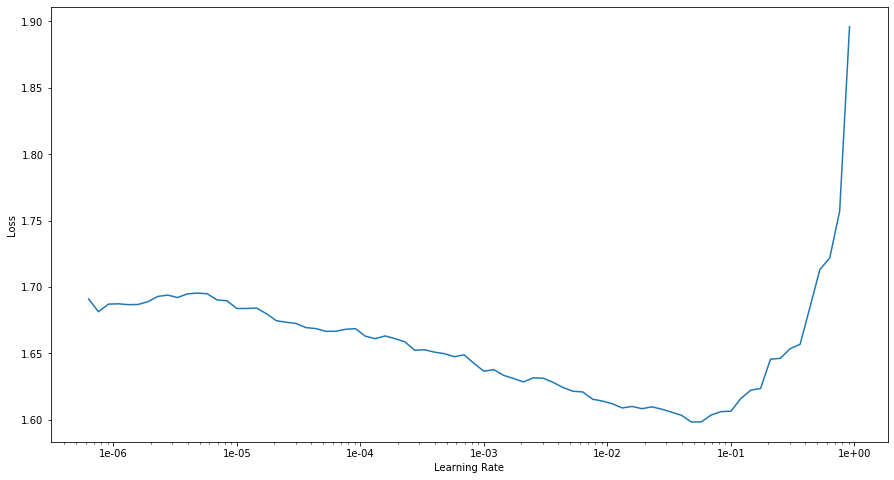

In [84]:
learn.lr_find()
learn.recorder.plot()

In [85]:
learn.fit_one_cycle(10, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.548714,1.525747,0.367946,00:02
1,1.049410,1.803941,0.361174,00:02
2,0.870571,1.802078,0.364936,00:02
3,0.556958,1.766101,0.368698,00:02
4,0.415828,1.658907,0.405568,00:02
5,0.369348,1.606358,0.414597,00:02
6,0.354054,1.594383,0.416855,00:02
7,0.349534,1.586197,0.422874,00:02
8,0.348274,1.599111,0.419865,00:02
9,0.347104,1.589249,0.422122,00:02
